In [6]:
import pandas as pd
import requests
import time
import unicodedata
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn.objects as so

In [7]:
RADIUS_METERS = 50
INPUT_SAMPLE = '../data/sample.csv'
OUTPUT_CSV = '../data/vias_extracted.csv'
VIAS_TOP_CSV = '../data/vias.csv'

In [8]:
def normalize_name(name):
    nfkd = unicodedata.normalize('NFKD', name.lower())
    return ''.join([c for c in nfkd if not unicodedata.combining(c)])

def fetch_from_overpass(lat, lon, radius=RADIUS_METERS):
    query = f"""
    [out:json][timeout:25];
    way(around:{radius},{lat},{lon});
    out tags;
    """
    url = "https://overpass-api.de/api/interpreter"
    try:
        response = requests.post(url, data={'data': query})
        if response.status_code == 200:
            data = response.json()
            if data.get('elements'):
                return data['elements'][0].get('tags', {})
    except Exception as e:
        print(f"❌ Error al consultar {lat}, {lon}: {e}")
    return {}

In [9]:
df = pd.read_csv(INPUT_SAMPLE)
df['road_name'] = df['road_name'].apply(normalize_name)

records = []
for _, row in df.iterrows():
    tags = fetch_from_overpass(row['latitude'], row['longitude'])
    record = {"road_name": row['road_name'], "latitude": row['latitude'], "longitude": row['longitude']}
    for key, value in tags.items():
        record[key] = value
    records.append(record)
    time.sleep(1)

df_result = pd.DataFrame(records)

In [10]:
print("dimensiones:", df_result.shape)
print("columnas:", df_result.columns.tolist())
print("tipos de datos:")
print(df_result.dtypes)

dimensiones: (103, 223)
columnas: ['road_name', 'latitude', 'longitude', 'building:colour', 'building:material', 'building:part', 'height', 'min_height', 'roof:colour', 'cycleway:right', 'highway', 'lane_markings', 'lit', 'name', 'name:ru', 'name_1', 'oneway', 'parking:both', 'parking:both:orientation', 'sidewalk:both', 'surface', 'tiger:cfcc', 'tiger:county', 'tiger:name_base', 'tiger:name_base_1', 'tiger:name_direction_prefix', 'tiger:name_direction_prefix_1', 'tiger:name_type', 'tiger:name_type_1', 'tiger:reviewed', 'tiger:zip_left', 'tiger:zip_right', 'building:levels', 'fixme', 'landuse', 'electrified', 'frequency', 'gauge', 'layer', 'level', 'network', 'note', 'operator', 'railway', 'railway:preferred_direction', 'tunnel', 'voltage', 'hgv', 'hgv:national_network', 'hgv:state_network', 'lanes', 'maxweight', 'sidewalk', 'source:hgv', 'wikipedia', 'handrail', 'incline', 'ramp', 'source', 'tactile_paving', 'cycleway:left', 'maxspeed', 'name:etymology:wikidata', 'oneway:bicycle', 'ser

In [11]:
print("valores nulos por columna:")
print(df_result.isnull().sum())
print("registros duplicados:", df_result.duplicated().sum())

valores nulos por columna:
road_name               0
latitude                0
longitude               0
building:colour       100
building:material     101
                     ... 
source:description    102
source:pkey           102
seamark:name          102
seamark:type          102
barrier               102
Length: 223, dtype: int64
registros duplicados: 0


In [12]:
print("estadisticas descriptivas:")
print(df_result.describe(include='all'))

estadisticas descriptivas:
                 road_name    latitude   longitude building:colour  \
count                  103  103.000000  103.000000               3   
unique                 103         NaN         NaN               2   
top     broadway, new york         NaN         NaN         #F4ECBB   
freq                     1         NaN         NaN               2   
mean                   NaN   31.922399  -14.647653             NaN   
std                    NaN   26.494121   79.953755             NaN   
min                    NaN  -37.814000 -122.419400             NaN   
25%                    NaN   31.248800  -79.361900             NaN   
50%                    NaN   40.712800   -0.139000             NaN   
75%                    NaN   48.859000   16.381900             NaN   
max                    NaN   59.967300  174.790300             NaN   

       building:material building:part height min_height roof:colour  \
count                  2             5      8          2    

In [13]:
categoricas = df_result.select_dtypes(include='object').columns.tolist()
for col in categoricas:
    print(f"distribución de '{col}':")
    print(df_result[col].value_counts(dropna=False).head(10))

distribución de 'road_name':
broadway, new york                         1
la rambla, barcelona (alt 12)              1
rua oscar freire, sao paulo (alt 22)       1
avenida paulista, sao paulo (alt 21)       1
orchard road, singapore (alt 20)           1
nathan road, hong kong (alt 19)            1
yonge street, toronto (alt 18)             1
queen street, toronto (alt 17)             1
lombard street, san francisco (alt 16)     1
columbus avenue, san francisco (alt 15)    1
Name: road_name, dtype: int64
distribución de 'building:colour':
NaN        100
#F4ECBB      2
#565E61      1
Name: building:colour, dtype: int64
distribución de 'building:material':
NaN      101
stone      2
Name: building:material, dtype: int64
distribución de 'building:part':
NaN       98
yes        4
office     1
Name: building:part, dtype: int64
distribución de 'height':
NaN     95
27       2
205      1
0.1      1
105      1
228      1
23       1
89.6     1
Name: height, dtype: int64
distribución de 'min_height

In [14]:
def convert_maxspeed(val):
    if pd.isna(val): return None
    for token in str(val).split():
        if token.isdigit():
            return int(token)
    return None

df_result['maxspeed_numeric'] = df_result['maxspeed'].apply(convert_maxspeed)

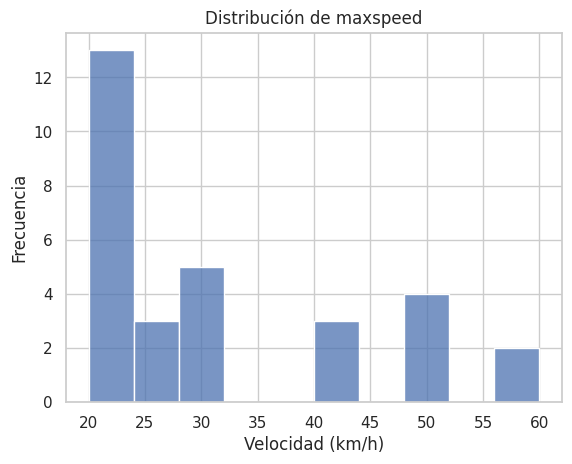

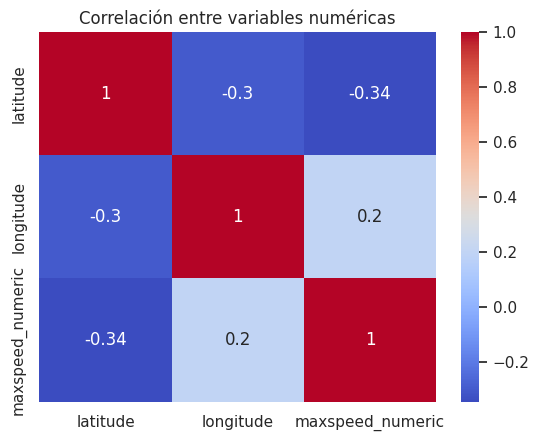

In [15]:
sns.set(style="whitegrid")

# Histograma de velocidad máxima
sns.histplot(df_result['maxspeed_numeric'].dropna(), bins=10)
plt.title("Distribución de maxspeed")
plt.xlabel("Velocidad (km/h)")
plt.ylabel("Frecuencia")
plt.show()

# Matriz de correlación numérica
numericas = df_result.select_dtypes(include='number')
correlation = numericas.corr()
sns.heatmap(correlation, annot=True, cmap="coolwarm")
plt.title("Correlación entre variables numéricas")
plt.show()

In [16]:
df_result['non_null_count'] = df_result.notnull().sum(axis=1)
df_top50 = df_result.sort_values(by='non_null_count', ascending=False).head(50)
df_top50[['road_name', 'latitude', 'longitude']].to_csv(VIAS_TOP_CSV, index=False)
print("\n✅ Vías más completas exportadas en:", VIAS_TOP_CSV)


✅ Vías más completas exportadas en: ../data/vias.csv
